In [1]:
import jax.numpy as jnp
from jax.lax import fori_loop
from jax.lax import scan
from jax import grad 
from jax import vmap
from jax import jit
from functools import partial

In [2]:
import jax
jax.__version__

'0.2.3'

In [3]:
#@jit
def f(x,null):
    x=1.0/(1.0+x)
    return x,null

In [4]:
def nojitg(x0):
    x,null=scan(f,x0,None,3)
    return x

In [5]:
@jit
def g(x0):
    x,null=scan(f,x0,None,3)
    return x

In [4]:
from jax import vmap
from jax import jit
xarr=jnp.linspace(0,1,100)

In [7]:
%timeit g(xarr)

130 µs ± 11.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
%timeit nojitg(xarr)

9.54 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
h=jit(vmap(grad(g)))
%timeit harr=h(xarr)

196 µs ± 3.94 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
h=(vmap(grad(nojitg)))
%timeit harr=h(xarr)

33.8 ms ± 753 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
class cjax(object):
    def __init__(self):
        self.c=0.0
        self.n = 3
        
    def f(self,x,null):
        x=self.c/(self.c+x)
        return x,null    
        
    def g(self,x0):
        x,null=scan(f,x0,None,self.n)
        return x
    
    def h(self,x0):
        return vmap(grad(g))(x0)

In [12]:
cc=cjax()
cc.c=2.0
cc.n=4
%timeit cc.g(xarr)

10 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit cc.h(xarr)

1.35 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
class fcjax(object):
    def __init__(self,c,n):
        self.c=c
        self.n=n
        
    def f(self,x,null):
        x=self.c/(self.c+x)
        return x,null    
    
    @partial(jit, static_argnums=(0,))
    def g(self,x0):
        x,null=scan(f,x0,None,self.n)
        return x
    
    @partial(jit, static_argnums=(0,))
    def h(self,x0):
        hh=vmap(grad(self.g))
        return hh(x0)
    

In [31]:
fcc=fcjax(1,3)
%timeit fcc.g(xarr)

139 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [32]:
%timeit fcc.h(xarr)

215 µs ± 5.15 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [33]:
hf=jit(vmap(grad(fcc.g)))
%timeit hf(xarr)

204 µs ± 1.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


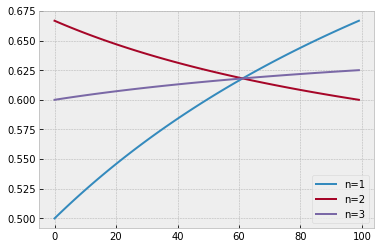

In [52]:
import matplotlib.pyplot as plt
fcc=fcjax(1.0,i)
for i in range(1,4):
    fcc=fcjax(1.0,i)
    fcc.n=i+1
    plt.plot(fcc.g(xarr),label="n="+str(i))
plt.legend()
plt.show()

In [58]:
fcc=fcjax(1.0,1)
fcc.n=3
print(fcc.h(xarr)[0])
fcc.n=4
print(fcc.h(xarr)[0])
fcc=fcjax(1.0,4)
print(fcc.h(xarr)[0])

-0.11111111
-0.11111111
0.039999995


In [5]:
import sympy as sp
x = sp.Symbol('x')
def f_sp(x):
    return 1/(1+x)
ans1=sp.diff(f_sp(x),x)
ans2=sp.diff(f_sp(f_sp(x)),x)
ans3=sp.diff(f_sp(f_sp(f_sp(x))),x)

In [44]:
ans1

-1/(x + 1)**2

In [45]:
ans2

1/((1 + 1/(x + 1))**2*(x + 1)**2)

In [46]:
ans3

-1/((1 + 1/(1 + 1/(x + 1)))**2*(1 + 1/(x + 1))**2*(x + 1)**2)

In [6]:
h_sp1=lambda x:-(f_sp(x))**2
h_sp2=lambda x:(f_sp(f_sp(x)))**2*(f_sp(x))**2
h_sp3=lambda x:-(f_sp(f_sp(f_sp(x))))**2*(f_sp(f_sp(x)))**2*(f_sp(x))**2

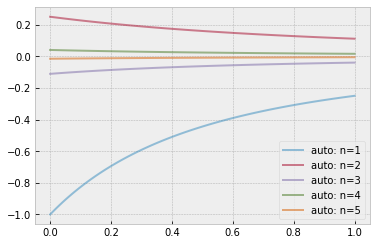

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')

fig=plt.figure()
ax=fig.add_subplot(111)
for i in range(1,6):
    fcc=fcjax()
    fcc.n=i
    fcc.c=1.0
    plt.plot(xarr,fcc.h(xarr),alpha=0.5,label="auto: n="+str(i))
#plt.plot(xarr,h_sp1(xarr),label="n=1",ls="dotted")
#plt.plot(xarr,h_sp2(xarr),label="n=2",ls="dotted")
#plt.plot(xarr,h_sp3(xarr),label="n=3",ls="dotted")
plt.legend()
plt.show()